In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Gesture Recognition Training for Summit AI Demo¶

* Read training data from local data file
* Convert time series into features
* Feature Selection
* Train and test Random Forest model
* Train and test Feed-Forward model
* Tune Parameters
* Save model for use by TF-Serve

<a href='#p2'>More Features</a>

In [2]:

import pandas as pd
import numpy as np
import scipy.stats
import time
import multiprocessing as mp
import json
import random
import os
import random
import matplotlib.pyplot as plt 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Redundent Random seed setting to ensure reproducible results  
random.seed(314)
np.random.seed(314)
tf.set_random_seed(314)

### Read Training Data from local data file

In [ ]:
exists = os.path.isdir('data/demo4-training-data/')
if exists:
    print("Data directory already exists")
else:
    ! tar xzfv data/demo4-training-data.tar.gz --directory data

In [4]:
def read_data_into_dataframe(gesture_paths):
    
    examples = []
    for file in gesture_paths:
        with open(file) as f:
            opened_file = json.loads(f.read())
        
        examples.append(opened_file)
    
    examples = pd.io.json.json_normalize(examples)
    
    return examples 

In [5]:
path_to_data = "data/demo4-training-data/training-data"

list_of_gesture_path = []
for root, dirs, files in os.walk(path_to_data):
    for f in files:
        list_of_gesture_path.append(os.path.join(root, f))

then = time.time()
Data = read_data_into_dataframe(list_of_gesture_path)
print((time.time()-then)/60,"minutes")
print(len(Data), "records read...")

0.05207904577255249 minutes
878 records read...


In [6]:
Data.head()

,gesture,motion,orientation,playerId,type,uuid
0,fever,"[[-0.07416, -0.07133, 0.08607, 131.95007, -122...","[[10.47292, 49.63966, -4.26736, 1552931372971]...",383cf1b0-1742-4f09-b3d0-bd0172303ced,motion,TfH4X5rUvPsazTLfyQHoa
1,fever,"[[-10.64323, 6.23453, 11.4453, 1551880365849],...","[[261.01163, 173.79432, 31.71075, 155188036584...",58abd56f-65b5-495d-9ad4-6ac50f99f7fc,motion,o1UkjE5z8zkyZjvmnHi_3
2,fever,"[[0.44704, -0.13077, -0.24348, 8.32742, -0.307...","[[265.30463, -161.41106, 63.44823, 15532910267...",9ad98b2e-51d5-498e-b553-957e1817b0c4,motion,KMiAMeODPnGpHi_I926lw
3,fever,"[[7.38393, -1.85632, 3.68812, 35.6506, 57.4797...","[[44.22412, 111.39533, 21.69619, 1553006614931...",71718821-4c51-442f-bcab-1e737415cab6,motion,_lR1iXWebJOfims4ASHYr
4,fever,"[[3.0489, 15.0825, -19.98269, 97.16633, -147.0...","[[1.29887, 34.25049, -1.92907, 1552931340010],...",55e6e7e3-d3d5-43a0-a118-0f58e5c6ab86,motion,AMZllOdy9gNt5FaHgUkHo


# rearrange the dataframe to analyze only the acceleration Data - 

In [7]:
def get_acceleration_data(df):
    re_arranged = []

    for row_index in range(len(Data)):

        x = [i[0] for i in df.iloc[row_index].motion]
        y = [i[1] for i in df.iloc[row_index].motion]
        z = [i[2] for i in df.iloc[row_index].motion]
        gesture = df.iloc[row_index].gesture

        entry = [x,y,z,gesture]
        re_arranged.append(entry)

    return pd.DataFrame(re_arranged, columns=["x","y","z","gesture"])
    

In [8]:
A_Data = get_acceleration_data(Data)

In [9]:
A_Data.head()

,x,y,z,gesture
0,"[-0.07416, -0.24589, -0.0417, -0.0496, -0.0205...","[-0.07133, -0.69474, -0.49047, -0.44221, -0.33...","[0.08607, -0.88767, -0.65553, -0.45573, 0.0382...",fever
1,"[-10.64323, -12.31247, -13.89531, -14.79117, -...","[6.23453, 7.83464, 10.11431, 11.59848, 12.9213...","[11.4453, 9.42268, 6.62164, 4.25434, 1.89684, ...",fever
2,"[0.44704, 2.4239, 2.4239, 6.43722, 8.43918, 11...","[-0.13077, 0.88016, 0.88016, 2.41199, 2.76819,...","[-0.24348, 0.05006, 0.05006, 0.62739, 0.9498, ...",fever
3,"[7.38393, 7.70563, 7.70563, 7.70563, 7.70563, ...","[-1.85632, -2.83689, -2.83689, -2.83689, -2.83...","[3.68812, 3.12265, 3.12265, 3.12265, 3.12265, ...",fever
4,"[3.0489, -0.07115, 0.04657, -0.18553, -0.28109...","[15.0825, 0.03972, -0.03551, -0.24618, -0.2438...","[-19.98269, 0.46124, 0.36401, 0.27336, 0.20655...",fever


### The below function takes a Dataframe of multiple dimensional time series data and generates a single fixed length feature vector based on taking statistics of each dimension

* **For each dimension we take:**
  <br/><br/>
    * mean over median 
    * std over median
    * length
    * kurtosis
    * histogram
    * mean over median 1st half of time series
    * mean over median 2nd half of time series
    * max signal power
    * estimated signal period 

In [10]:
def featurize(df_row, bins, columns):
    

    dimension_names = columns
    features = {}
    
    for ts, dim in zip(df_row,dimension_names):
        
        mean = np.mean(ts)
        median = np.median(ts)
        std = np.std(ts)
        length = len(ts)
        kurtosis = scipy.stats.kurtosis(ts)

        n, b = np.histogram(ts, 10)
        n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin

        if median == 0: 
            features[f'{dim}_mean_over_median'] =  0 #dimensionless            
            features[f'{dim}_std_over_median'] =  0 #dimensionless            
            features[f'{dim}_length'] = length
            features[f'{dim}_kurtosis'] = kurtosis #already dimensionless by definition
    

        else: 
            features[f'{dim}_mean_over_median'] =  mean/median #dimensionless            
            features[f'{dim}_std_over_median'] = std/median #dimensionless            
            features[f'{dim}_length'] = length
            features[f'{dim}_kurtosis'] = kurtosis #already dimensionless by definition


        for i, val in enumerate(n):
            features[f'{dim}_binfrac_{i}'] = val


        # new feature:
        midpoint = length//2
        ts_before = ts[:midpoint]
        ts_after = ts[midpoint:]

        mean_before = np.mean(ts_before) 
        mean_after = np.mean(ts_after)

        features[f'{dim}_mean_over_median_before'] = mean_before/median
        features[f'{dim}_mean_over_median_after'] = mean_after/median

        if length > 10:
            amp = np.fft.fft(ts)
            freq = np.fft.fftfreq(amp.size, 0.16)
            a_p = abs(amp.real[:1+len(amp)//2])
            f_p = freq[:1+len(freq)//2]

            max_power_index = np.argmax(abs(a_p[3:]))+3
            features[f'{dim}_max_power'] = abs(a_p[max_power_index])
            features[f'{dim}_period'] = f_p[max_power_index]
        else:
            features[f'{dim}_max_power'] = 0
            features[f'{dim}_period'] = 0


    features['label'] = df_row.gesture

    return features

In [11]:
featurize(A_Data.iloc[4],  10, ["x","y","z"])

{'x_mean_over_median': 1.1881587143248797,
 'x_std_over_median': -1.4820009830852265,
 'x_length': 322,
 'x_kurtosis': 1.6106004039344217,
 'x_binfrac_0': 0.006211180124223602,
 'x_binfrac_1': 0.018633540372670808,
 'x_binfrac_2': 0.018633540372670808,
 'x_binfrac_3': 0.040372670807453416,
 'x_binfrac_4': 0.062111801242236024,
 'x_binfrac_5': 0.08695652173913043,
 'x_binfrac_6': 0.30124223602484473,
 'x_binfrac_7': 0.2919254658385093,
 'x_binfrac_8': 0.11490683229813664,
 'x_binfrac_9': 0.059006211180124224,
 'x_mean_over_median_before': 1.0655301681686846,
 'x_mean_over_median_after': 1.310787260481075,
 'x_max_power': 564.0844035243831,
 'x_period': 0.15527950310559005,
 'y_mean_over_median': 1.0602795232713715,
 'y_std_over_median': 0.7056576223410903,
 'y_length': 322,
 'y_kurtosis': 0.06051989210368669,
 'y_binfrac_0': 0.009316770186335404,
 'y_binfrac_1': 0.009316770186335404,
 'y_binfrac_2': 0.09627329192546584,
 'y_binfrac_3': 0.12732919254658384,
 'y_binfrac_4': 0.260869565217

# Perform the featurizing on the entire test set

In [12]:
then = time.time()
examples = [] 
b = np.arange(1,100,10)
columns = ["x","y","z"]
for i in A_Data.index:
    example = featurize(A_Data.iloc[i], b,columns)
    examples.append(example)
    
print((time.time()-then)/60,"minutes")
    

0.027787371476491293 minutes


In [13]:
df = pd.DataFrame(examples)

In [14]:
df.head()

,label,x_binfrac_0,x_binfrac_1,x_binfrac_2,x_binfrac_3,x_binfrac_4,x_binfrac_5,x_binfrac_6,x_binfrac_7,x_binfrac_8,...,z_binfrac_8,z_binfrac_9,z_kurtosis,z_length,z_max_power,z_mean_over_median,z_mean_over_median_after,z_mean_over_median_before,z_period,z_std_over_median
0,fever,0.039877,0.018405,0.199387,0.242331,0.245399,0.134969,0.042945,0.033742,0.018405,...,0.039877,0.027607,1.486667,326,1402.959170,2.662926,2.555045,2.770806,0.095859,11.385388
1,fever,0.019324,0.057971,0.057971,0.106280,0.198068,0.173913,0.159420,0.101449,0.086957,...,0.043478,0.028986,-0.756022,207,219.888739,4.321581,15.216266,-6.678877,0.090580,59.933830
2,fever,0.003891,0.007782,0.062257,0.416342,0.233463,0.155642,0.050584,0.031128,0.019455,...,0.093385,0.046693,2.423836,257,361.536157,-0.431370,-1.328175,0.472442,0.218872,19.617541
3,fever,0.043344,0.065015,0.092879,0.148607,0.241486,0.263158,0.108359,0.012384,0.021672,...,0.092879,0.065015,-0.886425,323,897.773366,1.352943,1.285908,1.420394,0.077399,2.024637
4,fever,0.006211,0.018634,0.018634,0.040373,0.062112,0.086957,0.301242,0.291925,0.114907,...,0.027950,0.006211,2.430306,322,817.626988,0.500529,0.516190,0.484867,0.077640,-5.121865


### Clean Data by removing any examples that are less then ~5 seconds or 200, 16 ms intervals as we know that is the correct capture length of gestures

In [15]:
df = df[df["x_length"] > 200]
df = df.dropna()

In [16]:
# train test split the data set

In [17]:
train_df, test_df = train_test_split(df, train_size=0.75)

print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (614, 55)
test size = (205, 55)
roll             114
shake            114
fever            106
draw-circle       98
draw-triangle     98
floss             84
Name: label, dtype: int64
draw-triangle    40
draw-circle      36
roll             35
shake            33
floss            31
fever            30
Name: label, dtype: int64


### Train a random forest model to get a performance base-line

In [18]:
model = RandomForestClassifier(max_depth=3,min_samples_leaf=3,n_estimators=100)
    
model.fit(train_df.drop('label', axis=1), train_df['label'])

train_pred = model.predict(train_df.drop('label', axis=1))
train_labels = train_df['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_df.drop('label', axis=1))
test_labels = test_df['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

train acc = 0.7703583061889251, test_acc = 0.6926829268292682


### Generate a confusion matrix and classification report to see which gestures are difficult to learn

Text(0, 0.5, 'predicted')

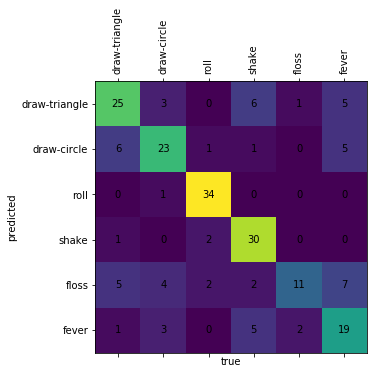

In [19]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_labels, test_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [20]:
print(classification_report(test_labels, test_pred, labels=labels))

               precision    recall  f1-score   support

draw-triangle       0.66      0.62      0.64        40
  draw-circle       0.68      0.64      0.66        36
         roll       0.87      0.97      0.92        35
        shake       0.68      0.91      0.78        33
        floss       0.79      0.35      0.49        31
        fever       0.53      0.63      0.58        30

    micro avg       0.69      0.69      0.69       205
    macro avg       0.70      0.69      0.68       205
 weighted avg       0.70      0.69      0.68       205



### Lets look only at the three Dance moves and see if we can get better performance. 

### Remove  simple gestures

In [21]:
df = df[df["label"]!= "shake"]
df = df[df["label"]!= "draw-triangle"]
df = df[df["label"]!="draw-circle"]

### Train test split

In [22]:
train_df, test_df = train_test_split(df, train_size=0.75)
train_df = train_df.dropna()
test_df = test_df.dropna()
print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (300, 55)
test size = (100, 55)
fever    105
roll     103
floss     92
Name: label, dtype: int64
roll     46
fever    31
floss    23
Name: label, dtype: int64


### Train Random Forest

In [23]:
model = RandomForestClassifier(max_depth=3,min_samples_leaf=3,n_estimators=100)
    
model.fit(train_df.drop('label', axis=1), train_df['label'])

train_pred = model.predict(train_df.drop('label', axis=1))
train_labels = train_df['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_df.drop('label', axis=1))
test_labels = test_df['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

train acc = 0.9333333333333333, test_acc = 0.82


Text(0, 0.5, 'predicted')

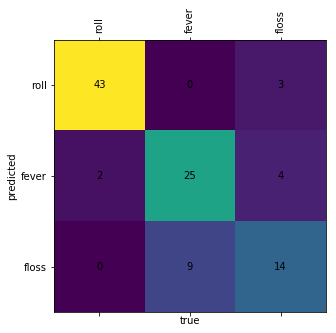

In [24]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_labels, test_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [25]:
print(classification_report(test_labels, test_pred, labels=labels))

              precision    recall  f1-score   support

        roll       0.96      0.93      0.95        46
       fever       0.74      0.81      0.77        31
       floss       0.67      0.61      0.64        23

   micro avg       0.82      0.82      0.82       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.82      0.82      0.82       100



In [26]:
df = pd.DataFrame(examples)
df = df[df["x_length"] > 200]
df = df.dropna()

In [27]:
train_df, test_df = train_test_split(df, train_size=0.75)

print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (614, 55)
test size = (205, 55)
roll             115
draw-triangle    109
draw-circle      103
shake            103
fever             99
floss             85
Name: label, dtype: int64
shake            44
fever            37
roll             34
draw-circle      31
floss            30
draw-triangle    29
Name: label, dtype: int64


In [28]:
train_label = np.array(train_df['label'])
test_label = np.array(test_df['label'])

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')

train_integer = label_encoder.fit_transform(train_label)
train_onehot = one_hot_encoder.fit_transform(train_integer.reshape(len(train_integer), 1))

test_integer = label_encoder.transform(test_label)
test_onehot = one_hot_encoder.transform(test_integer.reshape(len(test_integer), 1))

In [29]:
model_1 = keras.Sequential([
    keras.layers.Dense(25, activation=tf.nn.relu, input_shape=(54,)),
    keras.layers.Dense(6, activation=tf.nn.log_softmax)
]) 

Instructions for updating:
Colocations handled automatically by placer.


In [30]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)
model_1.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])


Instructions for updating:
Use tf.cast instead.


In [31]:
history = model_1.fit( train_df.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=0)

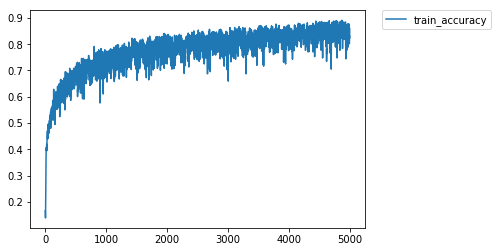

In [32]:
plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [33]:
test_loss, test_acc = model_1.evaluate(test_df.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

205/205 [==============================] - 0s 340us/sample - loss: 4.1559 - acc: 0.5415
Test accuracy: 0.54146343


In [34]:
y_hat = model_1.predict(test_df.drop('label', axis=1))
y_hat = y_hat.argmax(axis=1)
y_hat = label_encoder.inverse_transform(y_hat)

Text(0, 0.5, 'predicted')

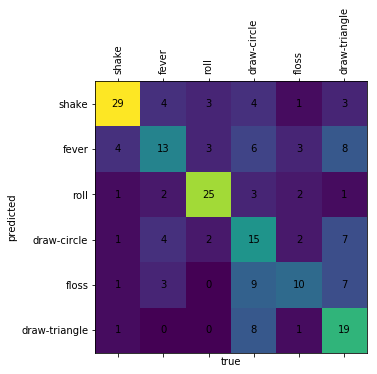

In [35]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_label, y_hat, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [36]:
print(classification_report(test_label, y_hat, labels=labels))

               precision    recall  f1-score   support

        shake       0.78      0.66      0.72        44
        fever       0.50      0.35      0.41        37
         roll       0.76      0.74      0.75        34
  draw-circle       0.33      0.48      0.39        31
        floss       0.53      0.33      0.41        30
draw-triangle       0.42      0.66      0.51        29

    micro avg       0.54      0.54      0.54       205
    macro avg       0.55      0.54      0.53       205
 weighted avg       0.57      0.54      0.54       205



In [37]:
df = pd.DataFrame(examples)
df = df[df["x_length"] > 200]
df = df.dropna()
df = df[df["label"]!= "shake"]
df = df[df["label"]!= "draw-triangle"]
df = df[df["label"]!="draw-circle"]

In [38]:
train_df, test_df = train_test_split(df, train_size=0.75)

print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (300, 55)
test size = (100, 55)
roll     112
fever    101
floss     87
Name: label, dtype: int64
roll     37
fever    35
floss    28
Name: label, dtype: int64


In [39]:
train_label = np.array(train_df['label'])
test_label = np.array(test_df['label'])

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')

train_integer = label_encoder.fit_transform(train_label)
train_onehot = one_hot_encoder.fit_transform(train_integer.reshape(len(train_integer), 1))

test_integer = label_encoder.transform(test_label)
test_onehot = one_hot_encoder.transform(test_integer.reshape(len(test_integer), 1))

In [40]:
model_2 = keras.Sequential([
    keras.layers.Dense(25, activation=tf.nn.relu, input_shape=(54,)),
    keras.layers.Dense(3, activation=tf.nn.log_softmax)
]) 

In [41]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)
model_2.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])


In [42]:
history = model_2.fit( train_df.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=0)

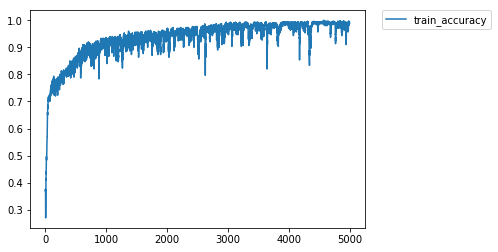

In [43]:
plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [44]:
test_loss, test_acc = model_2.evaluate(test_df.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

100/100 [==============================] - 0s 681us/sample - loss: 5.1292 - acc: 0.6800
Test accuracy: 0.68


In [45]:
y_hat = model_2.predict(test_df.drop('label', axis=1))
y_hat = y_hat.argmax(axis=1)
y_hat = label_encoder.inverse_transform(y_hat)

Text(0, 0.5, 'predicted')

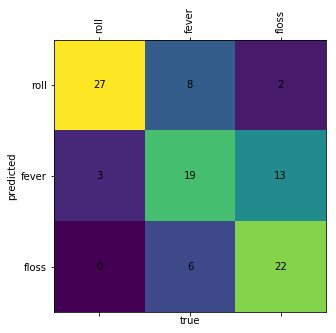

In [46]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_label, y_hat, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [47]:
print(classification_report(test_label, y_hat, labels=labels))

              precision    recall  f1-score   support

        roll       0.90      0.73      0.81        37
       fever       0.58      0.54      0.56        35
       floss       0.59      0.79      0.68        28

   micro avg       0.68      0.68      0.68       100
   macro avg       0.69      0.69      0.68       100
weighted avg       0.70      0.68      0.68       100



In [48]:
# Parameter tuneing: # of hidden nodes
acc = []

for i in range(3,50,1):

    model = keras.Sequential([
        keras.layers.Dense(i, activation=tf.nn.relu, input_shape=(54,)),
        keras.layers.Dense(3, activation=tf.nn.log_softmax)
    ]) 
    adm = tf.train.AdamOptimizer(learning_rate=1e-3)
    model.compile(optimizer=adm, 
                  loss=tf.losses.softmax_cross_entropy,
                  metrics=['accuracy'])

    history = model.fit( train_df.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=0)
    test_loss, test_acc = model.evaluate(test_df.drop('label', axis=1), test_onehot)
    acc.append((i,test_acc))
    print('Test accuracy:', test_acc,i)



100/100 [==============================] - 0s 716us/sample - loss: 1.0832 - acc: 0.3800
Test accuracy: 0.38 3
100/100 [==============================] - 0s 855us/sample - loss: 0.8147 - acc: 0.7100
Test accuracy: 0.71 4
100/100 [==============================] - 0s 1ms/sample - loss: 1.3258 - acc: 0.3700
Test accuracy: 0.37 5
100/100 [==============================] - 0s 901us/sample - loss: 0.5282 - acc: 0.8000
Test accuracy: 0.8 6
100/100 [==============================] - 0s 846us/sample - loss: 0.6829 - acc: 0.8000
Test accuracy: 0.8 7
100/100 [==============================] - 0s 916us/sample - loss: 1.0787 - acc: 0.7100
Test accuracy: 0.71 8
100/100 [==============================] - 0s 977us/sample - loss: 1.0347 - acc: 0.7700
Test accuracy: 0.77 9
100/100 [==============================] - 0s 930us/sample - loss: 1.1624 - acc: 0.7100
Test accuracy: 0.71 10
100/100 [==============================] - 0s 935us/sample - loss: 2.1036 - acc: 0.7700
Test accuracy: 0.77 11
100/100 [===

In [124]:
x = [i[0] for i in acc]
y = [i[1] for i in acc]

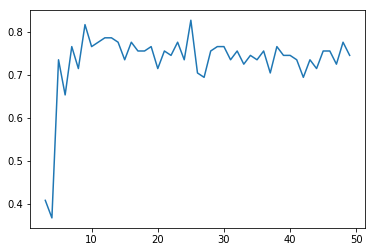

In [125]:
plt.plot(x,y)

In [127]:
# Parameter tune: # of hidden nodes 
#Same as above but with 100k epochs (2x above)

acc = []

for i in range(3,50,1):

    model = keras.Sequential([
        keras.layers.Dense(i, activation=tf.nn.relu, input_shape=(54,)),
        keras.layers.Dense(3, activation=tf.nn.log_softmax)
    ]) 
    adm = tf.train.AdamOptimizer(learning_rate=1e-3)
    model.compile(optimizer=adm, 
                  loss=tf.losses.softmax_cross_entropy,
                  metrics=['accuracy'])

    history = model.fit( train_df.drop('label', axis=1), train_onehot, epochs=10000, batch_size=100, verbose=0)
    test_loss, test_acc = model.evaluate(test_df.drop('label', axis=1), test_onehot)
    acc.append((i,test_acc))
    print('Test accuracy:', test_acc,i)


98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.3673469387755102 3
98/98 [==============================] - 1s 11ms/step
Test accuracy: 0.3673469387755102 4
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.7857142857142857 5
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.7448979591836735 6
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.7755102040816326 7
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.7551020408163265 8
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.673469387755102 9
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.7551020408163265 10
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.7755102040816326 11
98/98 [==============================] - 1s 12ms/step
Test accuracy: 0.7346938775510204 12
98/98 [==============================] - 1s 13ms/step
Test accuracy: 0.7653061224489796 13
98/98 [

In [128]:
x = [i[0] for i in acc]
y = [i[1] for i in acc]

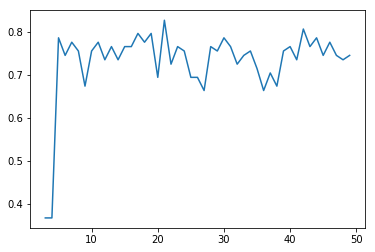

In [129]:
plt.plot(x,y)

In [137]:
# Parameter tune: # of hidden nodes in second layer with drop out
# Adding a layer and tuning second layer

acc = []

for i in range(3,50,1):

    model = keras.Sequential([
        keras.layers.Dense(25, activation=tf.nn.relu, input_shape=(54,)),
        keras.layers.Dropout(0.50),
        keras.layers.Dense(i, activation=tf.nn.relu),
        keras.layers.Dense(3, activation=tf.nn.log_softmax)
    ]) 

    adm = tf.train.AdamOptimizer(learning_rate=1e-3)

    model.compile(optimizer=adm, 
                  loss=tf.losses.softmax_cross_entropy,
                  metrics=['accuracy'])

    history = model.fit( train_df.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=0)

    test_loss, test_acc = model.evaluate(test_df.drop('label', axis=1), test_onehot)

    acc.append((i,test_acc))

    print('Test accuracy:', test_acc,i)


98/98 [==============================] - 2s 19ms/step
Test accuracy: 0.7653061224489796 3
98/98 [==============================] - 2s 19ms/step
Test accuracy: 0.3673469387755102 4
98/98 [==============================] - 2s 19ms/step
Test accuracy: 0.7755102040816326 5
98/98 [==============================] - 2s 20ms/step
Test accuracy: 0.7448979591836735 6
98/98 [==============================] - 2s 20ms/step
Test accuracy: 0.7448979591836735 7
98/98 [==============================] - 2s 21ms/step
Test accuracy: 0.7551020408163265 8
98/98 [==============================] - 2s 20ms/step
Test accuracy: 0.7244897959183674 9
98/98 [==============================] - 2s 21ms/step
Test accuracy: 0.6530612244897959 10
98/98 [==============================] - 2s 21ms/step
Test accuracy: 0.8163265306122449 11
98/98 [==============================] - 2s 21ms/step
Test accuracy: 0.7551020408163265 12
98/98 [==============================] - 2s 23ms/step
Test accuracy: 0.7959183673469388 13
98/98 

In [226]:
# Parameter tune: # of hidden nodes in second layer without drop out


acc = []

for i in range(3,50,1):

    model_nd = keras.Sequential([
        keras.layers.Dense(25, activation=tf.nn.relu, input_shape=(54,)),
        keras.layers.Dense(i, activation=tf.nn.relu),
        keras.layers.Dense(3, activation=tf.nn.log_softmax)
    ]) 

    adm = tf.train.AdamOptimizer(learning_rate=1e-3)

    model_nd.compile(optimizer=adm, 
                  loss=tf.losses.softmax_cross_entropy,
                  metrics=['accuracy'])

    history = model_nd.fit( train_df.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=0)

    test_loss, test_acc = model_nd.evaluate(test_df.drop('label', axis=1), test_onehot)

    acc.append((i,test_acc))

    print('Test accuracy:', test_acc,i)

98/98 [==============================] - 0s 1ms/step
Test accuracy: 0.6428571428571429 3
98/98 [==============================] - 0s 1ms/step
Test accuracy: 0.2857142857142857 4
98/98 [==============================] - 0s 1ms/step
Test accuracy: 0.5510204081632653 5
98/98 [==============================] - 0s 1ms/step
Test accuracy: 0.2653061224489796 6
98/98 [==============================] - 0s 1ms/step
Test accuracy: 0.2755102040816326 7
98/98 [==============================] - 0s 2ms/step
Test accuracy: 0.7244897959183674 8
98/98 [==============================] - 0s 2ms/step
Test accuracy: 0.7551020408163265 9
98/98 [==============================] - 0s 2ms/step
Test accuracy: 0.7040816326530612 10
98/98 [==============================] - 0s 2ms/step
Test accuracy: 0.7040816326530612 11
98/98 [==============================] - 0s 2ms/step
Test accuracy: 0.6428571428571429 12
98/98 [==============================] - 0s 2ms/step
Test accuracy: 0.6938775510204082 13
98/98 [==========

In [227]:
model_save_1 = keras.Sequential([
    keras.layers.Dense(25, activation=tf.nn.relu, input_shape=(54,)),
    keras.layers.Dense(3, activation=tf.nn.log_softmax)
]) 


In [229]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)

model_save_1.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])

history = model_save_1.fit( train_df.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=0)

test_loss, test_acc = model_save_1.evaluate(test_df.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

98/98 [==============================] - 1s 7ms/step
Test accuracy: 0.826530612244898


In [231]:
y_hat = model_save_1.predict(test_df.drop('label', axis=1))
y_hat = y_hat.argmax(axis=1)
y_hat = label_encoder.inverse_transform(y_hat)

Text(0, 0.5, 'predicted')

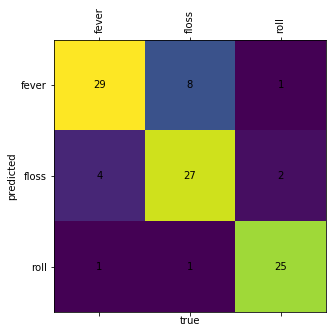

In [232]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_label, y_hat, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [233]:
print(classification_report(test_label, y_hat, labels=labels))

              precision    recall  f1-score   support

       fever       0.85      0.76      0.81        38
       floss       0.75      0.82      0.78        33
        roll       0.89      0.93      0.91        27

   micro avg       0.83      0.83      0.83        98
   macro avg       0.83      0.84      0.83        98
weighted avg       0.83      0.83      0.83        98



In [237]:
import os
from pathlib import Path
from datetime import datetime as dt

save =  True 
ver = int(dt.now().timestamp())

if save:
    for fmt in ['pb', 'hdf5','json']:
        # save model as hdf5
        MODEL_DIR = f"model_save_1_82_acc/{fmt}"
        export_path = Path(MODEL_DIR, str(ver))

        if fmt == 'pb':
            # simple_save cannot handle existing repository
            !rm -r {export_path}

            # Inspired by https://www.tensorflow.org/serving/tutorials/Serving_REST_simple
            # to save model for TF-serving
            tf.saved_model.simple_save(
                tf.keras.backend.get_session(),
                str(export_path),
                inputs={'input_data': model_save_1.input},
                outputs={t.name:t for t in model_save_1.outputs})
            
        elif fmt == 'hdf5':
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            model_path = Path(export_path, 'saved_model.h5') 
            
            # hdf5
            model_save_1.save(model_path)
            
        else:
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            # json
            model_spec_path = Path(
                export_path, 'saved_model_spec.json'
            )
            model_weights_path = Path(
                export_path, str(time.time()))
            
            model_spec_path.write_text(model_save_1.to_json(), encoding='utf-8')
            model_save_1.save_weights(str(model_weights_path))

        print('\nSaved model:')
        !ls -l {export_path}

rm: cannot remove ‘model_save_1_82_acc/pb/1553723474’: No such file or directory
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model_save_1_82_acc/pb/1553723474/saved_model.pb

Saved model:
total 7740
-rw-rw-r--. 1 mcliffor mcliffor 7922119 Mar 27 14:51 saved_model.pb
drwxr-xr-x. 2 mcliffor mcliffor    1024 Mar 27 14:51 variables

Saved model:
total 20
-rw-rw-r--. 1 mcliffor mcliffor 19896 Mar 27 14:51 saved_model.h5

Saved model:
total 31
-rw-rw-r--. 1 mcliffor mcliffor 22094 Mar 27 14:51 1553723480.1636646.data-00000-of-00001
-rw-rw-r--. 1 mcliffor mcliffor  1307 Mar 27 14:51 1553723480.1636646.index
-rw-rw-r--. 1 mcliffor mcliffor    93 Mar 27 14:51 checkpoint
-rw-rw-r--. 1 mcliffor mcliffor  1185 Mar 27 14:51 saved_model_spec.json


<a id='p2'></a>

# PART 2  EVEN MORE FEATURES 

Including the orientation data into our feature vector as well

In [7]:
def get_acceleration_and_orientation_data(df):
    re_arranged = []

    for row_index in range(len(Data)):

        x = [i[0] for i in df.iloc[row_index].motion]
        y = [i[1] for i in df.iloc[row_index].motion]
        z = [i[2] for i in df.iloc[row_index].motion]
        alpha = [i[0] for i in df.iloc[row_index].orientation]
        beta = [i[1] for i in df.iloc[row_index].orientation]
        gamma = [i[2] for i in df.iloc[row_index].orientation]
        gesture = df.iloc[row_index].gesture

        entry = [x, y, z, alpha, beta, gamma, gesture]
        re_arranged.append(entry)

    return pd.DataFrame(re_arranged, columns=["x","y","z","alpha","beta","gamma","gesture"])
    

In [8]:
B_Data = get_acceleration_and_orientation_data(Data)

In [9]:
B_Data.head()

,x,y,z,alpha,beta,gamma,gesture
0,[-2.81642],[-1.5614],[-0.97788],"[4.80787, 4.9188, 5.01804, 5.19668, 5.35103, 5...","[58.10896, 58.14502, 58.16093, 58.13456, 58.09...","[3.73614, 3.55983, 3.40379, 3.30659, 3.34045, ...",draw-circle
1,[],[],[],[356.09812],[1.66279],[0.76053],draw-circle
2,"[-12.9809, -9.46868, -7.03652, -1.59082, 3.899...","[-0.25897, 2.06525, 2.58216, 2.63155, 5.70526,...","[-3.26403, 2.20641, 1.93823, 0.49455, 0.03454,...","[292.22698, 293.36602, 294.28615, 296.80541, 3...","[44.09249, 47.86599, 50.20802, 55.35808, 60.31...","[70.54411, 66.27621, 63.97681, 58.69824, 52.34...",draw-circle
3,"[-12.07461, -13.27306, -13.26743, -13.59856, -...","[5.23257, 3.18079, 1.95103, -0.26545, -2.32471...","[-2.98558, -3.0077, -2.87265, -3.36066, -3.861...","[86.49483, 83.0223, 78.5032, 71.22467, 65.6595...","[78.62768, 76.71674, 74.86027, 72.5298, 70.964...","[-29.91469, -27.4213, -24.19585, -19.08307, -1...",draw-circle
4,"[-25.44857, -20.52717, -17.96698, -11.55767, -...","[16.63419, 18.51876, 19.80735, 22.16157, 23.56...","[-0.50768, -2.50973, -3.60222, -4.9406, -5.633...","[254.3068, 260.4193, 268.19214, 273.62494, 278...","[112.12048, 110.68234, 109.026, 107.92859, 107...","[86.17615, 78.62521, 68.34764, 60.79341, 53.85...",draw-circle


In [12]:
then = time.time()
examples = [] 
b = np.arange(1,100,10)
columns = ["x","y","z","alpha","beta","gamma"]
for i in B_Data.index:
    example = featurize(B_Data.iloc[i], b,columns)
    examples.append(example)
    
print((time.time()-then)/60,"minutes")
    

0.04726287126541138 minutes


In [13]:
examples[0]

{'x_mean_over_median': 1.0,
 'x_std_over_median': -0.0,
 'x_length': 1,
 'x_kurtosis': -3.0,
 'x_binfrac_0': 0.0,
 'x_binfrac_1': 0.0,
 'x_binfrac_2': 0.0,
 'x_binfrac_3': 0.0,
 'x_binfrac_4': 0.0,
 'x_binfrac_5': 1.0,
 'x_binfrac_6': 0.0,
 'x_binfrac_7': 0.0,
 'x_binfrac_8': 0.0,
 'x_binfrac_9': 0.0,
 'x_mean_over_median_before': nan,
 'x_mean_over_median_after': 1.0,
 'x_max_power': 0,
 'x_period': 0,
 'y_mean_over_median': 1.0,
 'y_std_over_median': -0.0,
 'y_length': 1,
 'y_kurtosis': -3.0,
 'y_binfrac_0': 0.0,
 'y_binfrac_1': 0.0,
 'y_binfrac_2': 0.0,
 'y_binfrac_3': 0.0,
 'y_binfrac_4': 0.0,
 'y_binfrac_5': 1.0,
 'y_binfrac_6': 0.0,
 'y_binfrac_7': 0.0,
 'y_binfrac_8': 0.0,
 'y_binfrac_9': 0.0,
 'y_mean_over_median_before': nan,
 'y_mean_over_median_after': 1.0,
 'y_max_power': 0,
 'y_period': 0,
 'z_mean_over_median': 1.0,
 'z_std_over_median': -0.0,
 'z_length': 1,
 'z_kurtosis': -3.0,
 'z_binfrac_0': 0.0,
 'z_binfrac_1': 0.0,
 'z_binfrac_2': 0.0,
 'z_binfrac_3': 0.0,
 'z_binfr

In [14]:
bf = pd.DataFrame(examples)

In [15]:
bf.head()

,alpha_binfrac_0,alpha_binfrac_1,alpha_binfrac_2,alpha_binfrac_3,alpha_binfrac_4,alpha_binfrac_5,alpha_binfrac_6,alpha_binfrac_7,alpha_binfrac_8,alpha_binfrac_9,...,z_binfrac_8,z_binfrac_9,z_kurtosis,z_length,z_max_power,z_mean_over_median,z_mean_over_median_after,z_mean_over_median_before,z_period,z_std_over_median
0,0.057143,0.038095,0.028571,0.028571,0.038095,0.047619,0.180952,0.133333,0.152381,0.295238,...,0.000000,0.000000,-3.000000,1,0.000000,1.000000,1.000000,NaN,0.000000,-0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,0,0.000000,NaN,NaN,NaN,0.000000,NaN
2,0.246231,0.060302,0.125628,0.000000,0.000000,0.000000,0.000000,0.040201,0.070352,0.457286,...,0.000000,0.018519,4.993345,108,68.193646,1.810502,-0.961406,4.582409,0.868056,12.248929
3,0.304762,0.228571,0.142857,0.023810,0.000000,0.000000,0.000000,0.028571,0.080952,0.190476,...,0.252381,0.190476,-0.652763,210,399.433046,1.239221,1.298908,1.179534,0.208333,-0.777379
4,0.205742,0.047847,0.000000,0.000000,0.000000,0.014354,0.066986,0.200957,0.253589,0.210526,...,0.274112,0.116751,-0.180958,197,291.249978,1.214303,0.520251,1.915438,0.190355,-1.124748


In [16]:
# Remove samples that are too small
bf = bf[bf["x_length"] > 200]

In [17]:
len(bf)

794

In [19]:
train_bf, test_bf = train_test_split(bf, train_size=0.75)
train_bf = train_bf.dropna()
test_bf = test_bf.dropna()
print(f'train size = {train_bf.shape}')
print(f'test size = {test_bf.shape}')

print(train_bf['label'].value_counts())
print(test_bf['label'].value_counts())

train size = (595, 109)
test size = (199, 109)
draw-triangle    113
roll             107
draw-circle       97
shake             96
fever             94
floss             88
Name: label, dtype: int64
shake            44
roll             38
fever            36
draw-circle      32
floss            27
draw-triangle    22
Name: label, dtype: int64


In [21]:
model = RandomForestClassifier(max_depth=3,min_samples_leaf=3,n_estimators=100)
    
model.fit(train_bf.drop('label', axis=1), train_bf['label'])

train_pred = model.predict(train_bf.drop('label', axis=1))
train_labels = train_bf['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_bf.drop('label', axis=1))
test_labels = test_bf['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

train acc = 0.7899159663865546, test_acc = 0.7437185929648241


Text(0, 0.5, 'predicted')

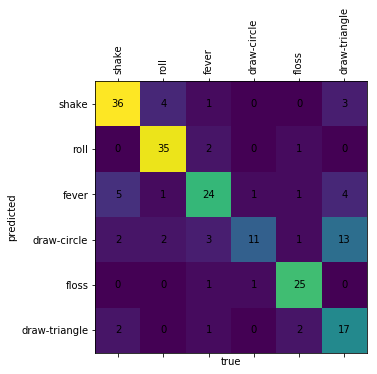

In [24]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_bf['label'].value_counts().index)

confusion = confusion_matrix(test_labels, test_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [25]:
print(classification_report(test_labels, test_pred, labels=labels))

               precision    recall  f1-score   support

        shake       0.80      0.82      0.81        44
         roll       0.83      0.92      0.88        38
        fever       0.75      0.67      0.71        36
  draw-circle       0.85      0.34      0.49        32
        floss       0.83      0.93      0.88        27
draw-triangle       0.46      0.77      0.58        22

    micro avg       0.74      0.74      0.74       199
    macro avg       0.75      0.74      0.72       199
 weighted avg       0.77      0.74      0.73       199



In [26]:
bf = bf[bf["label"]!= "shake"]
bf = bf[bf["label"]!= "draw-triangle"]
bf = bf[bf["label"]!="draw-circle"]

In [32]:
train_bf, test_bf = train_test_split(bf, train_size=0.75)
train_bf = train_bf.dropna()
test_bf = test_bf.dropna()
print(f'train size = {train_bf.shape}')
print(f'test size = {test_bf.shape}')

print(train_bf['label'].value_counts())
print(test_bf['label'].value_counts())

train size = (292, 109)
test size = (98, 109)
roll     107
fever    105
floss     80
Name: label, dtype: int64
roll     38
floss    35
fever    25
Name: label, dtype: int64


In [33]:
model = RandomForestClassifier(max_depth=3,min_samples_leaf=3,n_estimators=100)
    
model.fit(train_bf.drop('label', axis=1), train_bf['label'])

train_pred = model.predict(train_bf.drop('label', axis=1))
train_labels = train_bf['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_bf.drop('label', axis=1))
test_labels = test_bf['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

train acc = 0.934931506849315, test_acc = 0.8979591836734694


Text(0, 0.5, 'predicted')

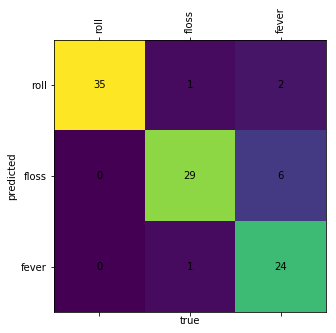

In [34]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_bf['label'].value_counts().index)

confusion = confusion_matrix(test_labels, test_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [35]:
print(classification_report(test_labels, test_pred, labels=labels))

              precision    recall  f1-score   support

        roll       1.00      0.92      0.96        38
       floss       0.94      0.83      0.88        35
       fever       0.75      0.96      0.84        25

   micro avg       0.90      0.90      0.90        98
   macro avg       0.90      0.90      0.89        98
weighted avg       0.91      0.90      0.90        98



In [54]:
bf = pd.DataFrame(examples)
bf = bf[bf["x_length"] > 200]

train_bf, test_bf = train_test_split(bf, train_size=0.75)
train_bf = train_bf.dropna()
test_bf = test_bf.dropna()

print(f'train size = {train_bf.shape}')
print(f'test size = {test_bf.shape}')

print(train_bf['label'].value_counts())
print(test_bf['label'].value_counts())

train size = (595, 109)
test size = (199, 109)
roll             114
shake            102
fever            101
draw-triangle     97
draw-circle       96
floss             85
Name: label, dtype: int64
shake            38
draw-triangle    38
draw-circle      33
roll             31
floss            30
fever            29
Name: label, dtype: int64


In [55]:
train_label = np.array(train_bf['label'])
test_label = np.array(test_bf['label'])

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')

train_integer = label_encoder.fit_transform(train_label)
train_onehot = one_hot_encoder.fit_transform(train_integer.reshape(len(train_integer), 1))

test_integer = label_encoder.transform(test_label)
test_onehot = one_hot_encoder.transform(test_integer.reshape(len(test_integer), 1))

In [57]:
model = keras.Sequential([
    keras.layers.Dense(100, activation=tf.nn.relu, input_shape=(108,)),
    keras.layers.Dense(6, activation=tf.nn.log_softmax)
]) 

In [58]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)
model.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])


In [59]:
history = model.fit( train_bf.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=0)

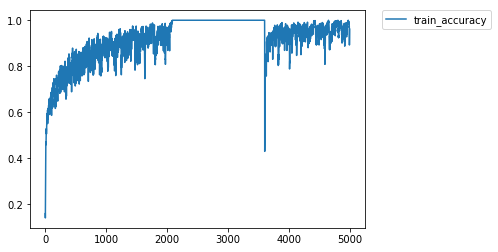

In [60]:
plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [61]:
test_loss, test_acc = model.evaluate(test_bf.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

199/199 [==============================] - 0s 233us/step
Test accuracy: 0.5326633174814771


In [62]:
bf = bf[bf["label"]!= "shake"]
bf = bf[bf["label"]!= "draw-triangle"]
bf = bf[bf["label"]!="draw-circle"]

In [63]:
train_bf, test_bf = train_test_split(bf, train_size=0.75)
train_bf = train_bf.dropna()
test_bf = test_bf.dropna()
print(f'train size = {train_bf.shape}')
print(f'test size = {test_bf.shape}')

print(train_bf['label'].value_counts())
print(test_bf['label'].value_counts())

train size = (292, 109)
test size = (98, 109)
roll     110
fever    101
floss     81
Name: label, dtype: int64
roll     35
floss    34
fever    29
Name: label, dtype: int64


In [64]:
train_label = np.array(train_bf['label'])
test_label = np.array(test_bf['label'])

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')

train_integer = label_encoder.fit_transform(train_label)
train_onehot = one_hot_encoder.fit_transform(train_integer.reshape(len(train_integer), 1))

test_integer = label_encoder.transform(test_label)
test_onehot = one_hot_encoder.transform(test_integer.reshape(len(test_integer), 1))

In [85]:
model = keras.Sequential([
    keras.layers.Dense(8, activation=tf.nn.relu, input_shape=(108,)),
    keras.layers.Dense(3, activation=tf.nn.log_softmax)
]) 

In [86]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)
model.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])


In [87]:
history = model.fit( train_bf.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=0)

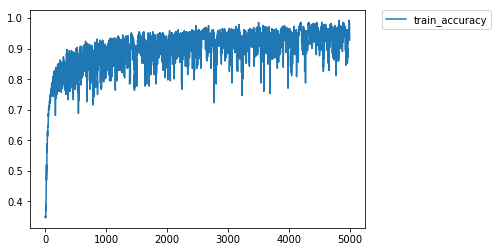

In [88]:
plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [89]:
test_loss, test_acc = model.evaluate(test_bf.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

98/98 [==============================] - 0s 693us/step
Test accuracy: 0.6938775510204082


### Maybe our feature vector is too long. Lets try to use PCA then predict

In [153]:
bf = pd.DataFrame(examples)
bf = bf[bf["x_length"] > 200]
bf = bf.dropna()

In [154]:
bf.head()

,alpha_binfrac_0,alpha_binfrac_1,alpha_binfrac_2,alpha_binfrac_3,alpha_binfrac_4,alpha_binfrac_5,alpha_binfrac_6,alpha_binfrac_7,alpha_binfrac_8,alpha_binfrac_9,...,z_binfrac_8,z_binfrac_9,z_kurtosis,z_length,z_max_power,z_mean_over_median,z_mean_over_median_after,z_mean_over_median_before,z_period,z_std_over_median
3,0.304762,0.228571,0.142857,0.023810,0.000000,0.000000,0.000000,0.028571,0.080952,0.190476,...,0.252381,0.190476,-0.652763,210,399.433046,1.239221,1.298908,1.179534,0.208333,-0.777379
8,0.090476,0.385714,0.028571,0.109524,0.042857,0.057143,0.066667,0.100000,0.085714,0.033333,...,0.042857,0.014286,-0.510035,210,102.597592,1.070724,0.947085,1.194362,0.327381,-1.371795
10,0.100304,0.115502,0.069909,0.185410,0.133739,0.316109,0.015198,0.000000,0.000000,0.063830,...,0.009494,0.009494,0.404437,316,298.907591,1.081910,0.582513,1.581306,0.098892,-1.597350
11,0.211604,0.054608,0.000000,0.000000,0.000000,0.000000,0.109215,0.116041,0.119454,0.389078,...,0.399194,0.205645,1.438242,248,326.302064,9.665959,9.798920,9.532998,0.075605,-20.871393
12,0.096970,0.021212,0.000000,0.000000,0.000000,0.033333,0.196970,0.330303,0.206061,0.115152,...,0.036364,0.015152,-0.200423,330,911.142382,-4.354719,-3.505882,-5.203557,0.113636,-25.922308


In [155]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
pca.fit(bf.drop('label', axis=1))

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [156]:
pdf = pd.DataFrame(pca.transform(bf.drop('label', axis=1)), columns=['PCA%i' % i for i in range(15)], index=bf.index)

In [159]:
x = pdf.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pdf = pd.DataFrame(x_scaled, index=pdf.index)

In [160]:
pdf["label"] = bf.label

In [161]:
pdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
3,0.017399,0.081295,0.326533,0.129035,0.406414,0.695013,0.120098,0.417662,0.218319,0.484349,0.368773,0.405705,0.316703,0.310173,0.349042,draw-circle
8,0.024739,0.061659,0.450668,0.076403,0.421571,0.356909,0.143879,0.416700,0.209017,0.486888,0.362474,0.401941,0.311126,0.329117,0.343599,draw-circle
10,0.011499,0.146928,0.367189,0.147979,0.417688,0.266778,0.139548,0.418155,0.291055,0.384931,0.530851,0.411439,0.311419,0.229790,0.354488,draw-circle
11,0.020633,0.248796,0.282004,0.086768,0.466889,0.245783,0.140649,0.420931,0.186591,0.492100,0.366772,0.401119,0.313298,0.194317,0.363929,draw-circle
12,0.082917,0.099936,0.660522,0.204720,0.482146,0.250167,0.150063,0.415692,0.227772,0.487173,0.363868,0.400322,0.309090,0.304713,0.347647,draw-circle


In [162]:
pdf = pdf[pdf["label"]!= "shake"]
pdf = pdf[pdf["label"]!= "draw-triangle"]
pdf = pdf[pdf["label"]!="draw-circle"]

In [163]:
train_pdf, test_pdf = train_test_split(pdf, train_size=0.75)
print(f'train size = {train_pdf.shape}')
print(f'test size = {test_pdf.shape}')

print(train_pdf['label'].value_counts())
print(test_pdf['label'].value_counts())

train size = (292, 16)
test size = (98, 16)
roll     114
fever     94
floss     84
Name: label, dtype: int64
fever    36
roll     31
floss    31
Name: label, dtype: int64


In [164]:
train_label = np.array(train_pdf['label'])
test_label = np.array(test_pdf['label'])

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')

train_integer = label_encoder.fit_transform(train_label)
train_onehot = one_hot_encoder.fit_transform(train_integer.reshape(len(train_integer), 1))

test_integer = label_encoder.transform(test_label)
test_onehot = one_hot_encoder.transform(test_integer.reshape(len(test_integer), 1))

In [168]:
model = keras.Sequential([
    keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(15,)),
    keras.layers.Dense(3, activation=tf.nn.log_softmax)
]) 

In [169]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)
model.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])

In [170]:
history = model.fit( train_pdf.drop('label', axis=1), train_onehot, epochs=5000, batch_size=100, verbose=1)

Epoch 1/5000
292/292 [==============================] - 0s 849us/step - loss: 1.1694 - acc: 0.2877
Epoch 2/5000
292/292 [==============================] - 0s 11us/step - loss: 1.1558 - acc: 0.2877
Epoch 3/5000
292/292 [==============================] - 0s 10us/step - loss: 1.1449 - acc: 0.2877
Epoch 4/5000
292/292 [==============================] - 0s 10us/step - loss: 1.1336 - acc: 0.2877
Epoch 5/5000
292/292 [==============================] - 0s 11us/step - loss: 1.1237 - acc: 0.2877
Epoch 6/5000
292/292 [==============================] - 0s 10us/step - loss: 1.1145 - acc: 0.2877
Epoch 7/5000
292/292 [==============================] - 0s 11us/step - loss: 1.1066 - acc: 0.2877
Epoch 8/5000
292/292 [==============================] - 0s 11us/step - loss: 1.0996 - acc: 0.2945
Epoch 9/5000
292/292 [==============================] - 0s 11us/step - loss: 1.0930 - acc: 0.3048
Epoch 10/5000
292/292 [==============================] - 0s 19us/step - loss: 1.0873 - acc: 0.3459
Epoch 11/5000
292/

292/292 [==============================] - 0s 13us/step - loss: 0.7642 - acc: 0.7123
Epoch 165/5000
292/292 [==============================] - 0s 11us/step - loss: 0.7624 - acc: 0.7123
Epoch 166/5000
292/292 [==============================] - 0s 11us/step - loss: 0.7608 - acc: 0.7123
Epoch 167/5000
292/292 [==============================] - 0s 10us/step - loss: 0.7590 - acc: 0.7158
Epoch 168/5000
292/292 [==============================] - 0s 11us/step - loss: 0.7576 - acc: 0.7226
Epoch 169/5000
292/292 [==============================] - 0s 16us/step - loss: 0.7562 - acc: 0.7158
Epoch 170/5000
292/292 [==============================] - 0s 14us/step - loss: 0.7542 - acc: 0.7158
Epoch 171/5000
292/292 [==============================] - 0s 17us/step - loss: 0.7526 - acc: 0.7295
Epoch 172/5000
292/292 [==============================] - 0s 14us/step - loss: 0.7510 - acc: 0.7260
Epoch 173/5000
292/292 [==============================] - 0s 12us/step - loss: 0.7494 - acc: 0.7226
Epoch 174/5000


292/292 [==============================] - 0s 12us/step - loss: 0.6577 - acc: 0.7466
Epoch 247/5000
292/292 [==============================] - 0s 15us/step - loss: 0.6565 - acc: 0.7432
Epoch 248/5000
292/292 [==============================] - 0s 15us/step - loss: 0.6556 - acc: 0.7432
Epoch 249/5000
292/292 [==============================] - 0s 14us/step - loss: 0.6549 - acc: 0.7432
Epoch 250/5000
292/292 [==============================] - 0s 13us/step - loss: 0.6537 - acc: 0.7432
Epoch 251/5000
292/292 [==============================] - 0s 12us/step - loss: 0.6530 - acc: 0.7466
Epoch 252/5000
292/292 [==============================] - 0s 12us/step - loss: 0.6520 - acc: 0.7432
Epoch 253/5000
292/292 [==============================] - 0s 13us/step - loss: 0.6509 - acc: 0.7432
Epoch 254/5000
292/292 [==============================] - 0s 20us/step - loss: 0.6501 - acc: 0.7466
Epoch 255/5000
292/292 [==============================] - 0s 17us/step - loss: 0.6491 - acc: 0.7466
Epoch 256/5000


292/292 [==============================] - 0s 15us/step - loss: 0.5994 - acc: 0.7705
Epoch 329/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5991 - acc: 0.7705
Epoch 330/5000
292/292 [==============================] - 0s 17us/step - loss: 0.5986 - acc: 0.7671
Epoch 331/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5980 - acc: 0.7671
Epoch 332/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5974 - acc: 0.7671
Epoch 333/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5970 - acc: 0.7671
Epoch 334/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5964 - acc: 0.7671
Epoch 335/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5964 - acc: 0.7705
Epoch 336/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5955 - acc: 0.7740
Epoch 337/5000
292/292 [==============================] - 0s 20us/step - loss: 0.5950 - acc: 0.7740
Epoch 338/5000


292/292 [==============================] - 0s 19us/step - loss: 0.5672 - acc: 0.7808
Epoch 411/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5670 - acc: 0.7808
Epoch 412/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5667 - acc: 0.7774
Epoch 413/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5664 - acc: 0.7774
Epoch 414/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5663 - acc: 0.7808
Epoch 415/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5659 - acc: 0.7774
Epoch 416/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5657 - acc: 0.7877
Epoch 417/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5653 - acc: 0.7842
Epoch 418/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5651 - acc: 0.7842
Epoch 419/5000
292/292 [==============================] - 0s 18us/step - loss: 0.5646 - acc: 0.7877
Epoch 420/5000


292/292 [==============================] - 0s 15us/step - loss: 0.5479 - acc: 0.7877
Epoch 493/5000
292/292 [==============================] - 0s 21us/step - loss: 0.5478 - acc: 0.7877
Epoch 494/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5476 - acc: 0.7877
Epoch 495/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5477 - acc: 0.7842
Epoch 496/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5474 - acc: 0.7842
Epoch 497/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5470 - acc: 0.7842
Epoch 498/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5470 - acc: 0.7842
Epoch 499/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5469 - acc: 0.7842
Epoch 500/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5464 - acc: 0.7842
Epoch 501/5000
292/292 [==============================] - 0s 18us/step - loss: 0.5462 - acc: 0.7842
Epoch 502/5000


292/292 [==============================] - 0s 12us/step - loss: 0.5356 - acc: 0.7808
Epoch 575/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5357 - acc: 0.7808
Epoch 576/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5353 - acc: 0.7808
Epoch 577/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5354 - acc: 0.7774
Epoch 578/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5351 - acc: 0.7774
Epoch 579/5000
292/292 [==============================] - 0s 18us/step - loss: 0.5351 - acc: 0.7774
Epoch 580/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5349 - acc: 0.7774
Epoch 581/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5347 - acc: 0.7774
Epoch 582/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5347 - acc: 0.7774
Epoch 583/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5344 - acc: 0.7774
Epoch 584/5000


292/292 [==============================] - 0s 14us/step - loss: 0.5275 - acc: 0.7740
Epoch 657/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5273 - acc: 0.7740
Epoch 658/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5270 - acc: 0.7774
Epoch 659/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5269 - acc: 0.7774
Epoch 660/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5269 - acc: 0.7740
Epoch 661/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5274 - acc: 0.7705
Epoch 662/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5268 - acc: 0.7808
Epoch 663/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5266 - acc: 0.7774
Epoch 664/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5263 - acc: 0.7808
Epoch 665/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5262 - acc: 0.7808
Epoch 666/5000


292/292 [==============================] - 0s 15us/step - loss: 0.5213 - acc: 0.7671
Epoch 739/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5208 - acc: 0.7740
Epoch 740/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5207 - acc: 0.7740
Epoch 741/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5205 - acc: 0.7705
Epoch 742/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5204 - acc: 0.7705
Epoch 743/5000
292/292 [==============================] - 0s 17us/step - loss: 0.5203 - acc: 0.7705
Epoch 744/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5203 - acc: 0.7705
Epoch 745/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5202 - acc: 0.7671
Epoch 746/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5203 - acc: 0.7671
Epoch 747/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5200 - acc: 0.7740
Epoch 748/5000


292/292 [==============================] - 0s 11us/step - loss: 0.5163 - acc: 0.7740
Epoch 821/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5158 - acc: 0.7774
Epoch 822/5000
292/292 [==============================] - 0s 18us/step - loss: 0.5160 - acc: 0.7774
Epoch 823/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5156 - acc: 0.7774
Epoch 824/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5156 - acc: 0.7740
Epoch 825/5000
292/292 [==============================] - 0s 19us/step - loss: 0.5158 - acc: 0.7740
Epoch 826/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5156 - acc: 0.7705
Epoch 827/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5155 - acc: 0.7740
Epoch 828/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5156 - acc: 0.7705
Epoch 829/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5154 - acc: 0.7740
Epoch 830/5000


292/292 [==============================] - 0s 20us/step - loss: 0.5129 - acc: 0.7705
Epoch 903/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5121 - acc: 0.7705
Epoch 904/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5120 - acc: 0.7705
Epoch 905/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5123 - acc: 0.7740
Epoch 906/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5124 - acc: 0.7740
Epoch 907/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5120 - acc: 0.7740
Epoch 908/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5121 - acc: 0.7740
Epoch 909/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5119 - acc: 0.7774
Epoch 910/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5120 - acc: 0.7808
Epoch 911/5000
292/292 [==============================] - 0s 10us/step - loss: 0.5120 - acc: 0.7740
Epoch 912/5000


292/292 [==============================] - 0s 12us/step - loss: 0.5097 - acc: 0.7740
Epoch 985/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5095 - acc: 0.7740
Epoch 986/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5094 - acc: 0.7740
Epoch 987/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5093 - acc: 0.7740
Epoch 988/5000
292/292 [==============================] - 0s 19us/step - loss: 0.5091 - acc: 0.7740
Epoch 989/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5091 - acc: 0.7705
Epoch 990/5000
292/292 [==============================] - 0s 19us/step - loss: 0.5093 - acc: 0.7740
Epoch 991/5000
292/292 [==============================] - 0s 19us/step - loss: 0.5091 - acc: 0.7740
Epoch 992/5000
292/292 [==============================] - 0s 19us/step - loss: 0.5092 - acc: 0.7740
Epoch 993/5000
292/292 [==============================] - 0s 17us/step - loss: 0.5091 - acc: 0.7705
Epoch 994/5000


292/292 [==============================] - 0s 14us/step - loss: 0.5054 - acc: 0.7705
Epoch 1147/5000
292/292 [==============================] - 0s 17us/step - loss: 0.5051 - acc: 0.7705
Epoch 1148/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5053 - acc: 0.7740
Epoch 1149/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5057 - acc: 0.7740
Epoch 1150/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5051 - acc: 0.7740
Epoch 1151/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5051 - acc: 0.7740
Epoch 1152/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5053 - acc: 0.7774
Epoch 1153/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5052 - acc: 0.7740
Epoch 1154/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5050 - acc: 0.7740
Epoch 1155/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5059 - acc: 0.7671
Epoch 

292/292 [==============================] - 0s 17us/step - loss: 0.5022 - acc: 0.7808
Epoch 1308/5000
292/292 [==============================] - 0s 16us/step - loss: 0.5025 - acc: 0.7842
Epoch 1309/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5026 - acc: 0.7808
Epoch 1310/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5026 - acc: 0.7808
Epoch 1311/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5022 - acc: 0.7808
Epoch 1312/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5023 - acc: 0.7808
Epoch 1313/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5024 - acc: 0.7808
Epoch 1314/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5022 - acc: 0.7808
Epoch 1315/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5021 - acc: 0.7808
Epoch 1316/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5026 - acc: 0.7774
Epoch 

292/292 [==============================] - 0s 11us/step - loss: 0.5001 - acc: 0.7842
Epoch 1470/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4999 - acc: 0.7842
Epoch 1471/5000
292/292 [==============================] - 0s 22us/step - loss: 0.4999 - acc: 0.7842
Epoch 1472/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5000 - acc: 0.7842
Epoch 1473/5000
292/292 [==============================] - 0s 15us/step - loss: 0.5001 - acc: 0.7842
Epoch 1474/5000
292/292 [==============================] - 0s 14us/step - loss: 0.5003 - acc: 0.7842
Epoch 1475/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5004 - acc: 0.7877
Epoch 1476/5000
292/292 [==============================] - 0s 11us/step - loss: 0.5001 - acc: 0.7842
Epoch 1477/5000
292/292 [==============================] - 0s 13us/step - loss: 0.5000 - acc: 0.7842
Epoch 1478/5000
292/292 [==============================] - 0s 12us/step - loss: 0.5004 - acc: 0.7842
Epoch 

292/292 [==============================] - 0s 11us/step - loss: 0.4981 - acc: 0.7842
Epoch 1632/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4983 - acc: 0.7911
Epoch 1633/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4981 - acc: 0.7842
Epoch 1634/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4984 - acc: 0.7877
Epoch 1635/5000
292/292 [==============================] - 0s 19us/step - loss: 0.4982 - acc: 0.7911
Epoch 1636/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4980 - acc: 0.7911
Epoch 1637/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4980 - acc: 0.7911
Epoch 1638/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4986 - acc: 0.7877
Epoch 1639/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4980 - acc: 0.7877
Epoch 1640/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4979 - acc: 0.7911
Epoch 

292/292 [==============================] - 0s 12us/step - loss: 0.4965 - acc: 0.7945
Epoch 1794/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4965 - acc: 0.7979
Epoch 1795/5000
292/292 [==============================] - 0s 20us/step - loss: 0.4965 - acc: 0.7979
Epoch 1796/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4963 - acc: 0.7945
Epoch 1797/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4963 - acc: 0.7945
Epoch 1798/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4968 - acc: 0.7979
Epoch 1799/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4964 - acc: 0.7979
Epoch 1800/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4963 - acc: 0.7945
Epoch 1801/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4966 - acc: 0.7945
Epoch 1802/5000
292/292 [==============================] - 0s 22us/step - loss: 0.4964 - acc: 0.7911
Epoch 

292/292 [==============================] - 0s 13us/step - loss: 0.4930 - acc: 0.7979
Epoch 1956/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4927 - acc: 0.8014
Epoch 1957/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4928 - acc: 0.7979
Epoch 1958/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4928 - acc: 0.7945
Epoch 1959/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4927 - acc: 0.7979
Epoch 1960/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4929 - acc: 0.7945
Epoch 1961/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4927 - acc: 0.7979
Epoch 1962/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4927 - acc: 0.7979
Epoch 1963/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4926 - acc: 0.7979
Epoch 1964/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4927 - acc: 0.7945
Epoch 

292/292 [==============================] - 0s 12us/step - loss: 0.4905 - acc: 0.8048
Epoch 2118/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4909 - acc: 0.8014
Epoch 2119/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4904 - acc: 0.8014
Epoch 2120/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4907 - acc: 0.8014
Epoch 2121/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4905 - acc: 0.8014
Epoch 2122/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4906 - acc: 0.8014
Epoch 2123/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4905 - acc: 0.8014
Epoch 2124/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4905 - acc: 0.8014
Epoch 2125/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4905 - acc: 0.8014
Epoch 2126/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4906 - acc: 0.8014
Epoch 

292/292 [==============================] - 0s 13us/step - loss: 0.4886 - acc: 0.7979
Epoch 2280/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4887 - acc: 0.7979
Epoch 2281/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4884 - acc: 0.7979
Epoch 2282/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4885 - acc: 0.8014
Epoch 2283/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4889 - acc: 0.7979
Epoch 2284/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4885 - acc: 0.8014
Epoch 2285/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4884 - acc: 0.8014
Epoch 2286/5000
292/292 [==============================] - 0s 22us/step - loss: 0.4884 - acc: 0.8014
Epoch 2287/5000
292/292 [==============================] - 0s 19us/step - loss: 0.4883 - acc: 0.8014
Epoch 2288/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4883 - acc: 0.8014
Epoch 

292/292 [==============================] - 0s 16us/step - loss: 0.4863 - acc: 0.7979
Epoch 2442/5000
292/292 [==============================] - 0s 20us/step - loss: 0.4864 - acc: 0.7979
Epoch 2443/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4868 - acc: 0.7979
Epoch 2444/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4862 - acc: 0.7979
Epoch 2445/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4862 - acc: 0.7979
Epoch 2446/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4866 - acc: 0.8014
Epoch 2447/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4865 - acc: 0.8014
Epoch 2448/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4864 - acc: 0.8014
Epoch 2449/5000
292/292 [==============================] - 0s 18us/step - loss: 0.4864 - acc: 0.8014
Epoch 2450/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4864 - acc: 0.7979
Epoch 

292/292 [==============================] - 0s 13us/step - loss: 0.4847 - acc: 0.8014
Epoch 2604/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4846 - acc: 0.8014
Epoch 2605/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4843 - acc: 0.8014
Epoch 2606/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4845 - acc: 0.8014
Epoch 2607/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4842 - acc: 0.7979
Epoch 2608/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4848 - acc: 0.8014
Epoch 2609/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4841 - acc: 0.8014
Epoch 2610/5000
292/292 [==============================] - 0s 18us/step - loss: 0.4850 - acc: 0.8014
Epoch 2611/5000
292/292 [==============================] - 0s 19us/step - loss: 0.4840 - acc: 0.7979
Epoch 2612/5000
292/292 [==============================] - 0s 18us/step - loss: 0.4842 - acc: 0.7979
Epoch 

292/292 [==============================] - 0s 12us/step - loss: 0.4810 - acc: 0.7979
Epoch 2765/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4809 - acc: 0.7979
Epoch 2766/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4810 - acc: 0.7979
Epoch 2767/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4816 - acc: 0.7979
Epoch 2768/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4808 - acc: 0.7979
Epoch 2769/5000
292/292 [==============================] - 0s 19us/step - loss: 0.4809 - acc: 0.7979
Epoch 2770/5000
292/292 [==============================] - 0s 19us/step - loss: 0.4808 - acc: 0.7979
Epoch 2771/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4811 - acc: 0.7979
Epoch 2772/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4807 - acc: 0.7979
Epoch 2773/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4808 - acc: 0.7979
Epoch 

292/292 [==============================] - 0s 15us/step - loss: 0.4773 - acc: 0.7979
Epoch 2927/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4774 - acc: 0.7979
Epoch 2928/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4774 - acc: 0.7979
Epoch 2929/5000
292/292 [==============================] - 0s 19us/step - loss: 0.4772 - acc: 0.8014
Epoch 2930/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4775 - acc: 0.7979
Epoch 2931/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4771 - acc: 0.7979
Epoch 2932/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4770 - acc: 0.7979
Epoch 2933/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4772 - acc: 0.7979
Epoch 2934/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4775 - acc: 0.8014
Epoch 2935/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4772 - acc: 0.8014
Epoch 

292/292 [==============================] - 0s 11us/step - loss: 0.4732 - acc: 0.8014
Epoch 3089/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4731 - acc: 0.8014
Epoch 3090/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4733 - acc: 0.7979
Epoch 3091/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4732 - acc: 0.7979
Epoch 3092/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4731 - acc: 0.7979
Epoch 3093/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4730 - acc: 0.7979
Epoch 3094/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4731 - acc: 0.8014
Epoch 3095/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4730 - acc: 0.7979
Epoch 3096/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4729 - acc: 0.7979
Epoch 3097/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4730 - acc: 0.8014
Epoch 

292/292 [==============================] - 0s 12us/step - loss: 0.4685 - acc: 0.8014
Epoch 3251/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4684 - acc: 0.7979
Epoch 3252/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4683 - acc: 0.7979
Epoch 3253/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4689 - acc: 0.7979
Epoch 3254/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4683 - acc: 0.7979
Epoch 3255/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4686 - acc: 0.7979
Epoch 3256/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4681 - acc: 0.8048
Epoch 3257/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4683 - acc: 0.8048
Epoch 3258/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4685 - acc: 0.8048
Epoch 3259/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4683 - acc: 0.8048
Epoch 

292/292 [==============================] - 0s 17us/step - loss: 0.4632 - acc: 0.7979
Epoch 3413/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4636 - acc: 0.7979
Epoch 3414/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4636 - acc: 0.7979
Epoch 3415/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4631 - acc: 0.7979
Epoch 3416/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4629 - acc: 0.7979
Epoch 3417/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4629 - acc: 0.7979
Epoch 3418/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4634 - acc: 0.7979
Epoch 3419/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4630 - acc: 0.8048
Epoch 3420/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4627 - acc: 0.8048
Epoch 3421/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4630 - acc: 0.8048
Epoch 

292/292 [==============================] - 0s 12us/step - loss: 0.4580 - acc: 0.7945
Epoch 3575/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4581 - acc: 0.7945
Epoch 3576/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4581 - acc: 0.7945
Epoch 3577/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4580 - acc: 0.8048
Epoch 3578/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4580 - acc: 0.8048
Epoch 3579/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4578 - acc: 0.8048
Epoch 3580/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4583 - acc: 0.8082
Epoch 3581/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4579 - acc: 0.8014
Epoch 3582/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4577 - acc: 0.7979
Epoch 3583/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4580 - acc: 0.7979
Epoch 

292/292 [==============================] - 0s 14us/step - loss: 0.4526 - acc: 0.8014
Epoch 3737/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4528 - acc: 0.8014
Epoch 3738/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4525 - acc: 0.8014
Epoch 3739/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4524 - acc: 0.8014
Epoch 3740/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4531 - acc: 0.7979
Epoch 3741/5000
292/292 [==============================] - 0s 18us/step - loss: 0.4525 - acc: 0.8014
Epoch 3742/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4524 - acc: 0.8014
Epoch 3743/5000
292/292 [==============================] - 0s 18us/step - loss: 0.4528 - acc: 0.7979
Epoch 3744/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4527 - acc: 0.8014
Epoch 3745/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4523 - acc: 0.8014
Epoch 

292/292 [==============================] - 0s 11us/step - loss: 0.4468 - acc: 0.8014
Epoch 3899/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4470 - acc: 0.8014
Epoch 3900/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4466 - acc: 0.8014
Epoch 3901/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4465 - acc: 0.8014
Epoch 3902/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4466 - acc: 0.8014
Epoch 3903/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4463 - acc: 0.8014
Epoch 3904/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4462 - acc: 0.8014
Epoch 3905/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4466 - acc: 0.8014
Epoch 3906/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4474 - acc: 0.8014
Epoch 3907/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4465 - acc: 0.8014
Epoch 

292/292 [==============================] - 0s 12us/step - loss: 0.4402 - acc: 0.8014
Epoch 4061/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4404 - acc: 0.8014
Epoch 4062/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4402 - acc: 0.8014
Epoch 4063/5000
292/292 [==============================] - 0s 17us/step - loss: 0.4408 - acc: 0.8014
Epoch 4064/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4401 - acc: 0.8014
Epoch 4065/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4406 - acc: 0.8014
Epoch 4066/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4402 - acc: 0.8014
Epoch 4067/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4400 - acc: 0.8014
Epoch 4068/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4403 - acc: 0.8048
Epoch 4069/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4400 - acc: 0.8048
Epoch 

292/292 [==============================] - 0s 14us/step - loss: 0.4347 - acc: 0.8014
Epoch 4223/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4341 - acc: 0.8082
Epoch 4224/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4342 - acc: 0.8082
Epoch 4225/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4341 - acc: 0.8082
Epoch 4226/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4341 - acc: 0.8082
Epoch 4227/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4340 - acc: 0.8082
Epoch 4228/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4338 - acc: 0.8116
Epoch 4229/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4338 - acc: 0.8116
Epoch 4230/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4341 - acc: 0.8151
Epoch 4231/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4341 - acc: 0.8151
Epoch 

292/292 [==============================] - 0s 13us/step - loss: 0.4269 - acc: 0.8116
Epoch 4385/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4270 - acc: 0.8116
Epoch 4386/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4268 - acc: 0.8116
Epoch 4387/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4267 - acc: 0.8151
Epoch 4388/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4270 - acc: 0.8151
Epoch 4389/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4269 - acc: 0.8219
Epoch 4390/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4270 - acc: 0.8185
Epoch 4391/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4268 - acc: 0.8185
Epoch 4392/5000
292/292 [==============================] - 0s 20us/step - loss: 0.4268 - acc: 0.8151
Epoch 4393/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4265 - acc: 0.8116
Epoch 

292/292 [==============================] - 0s 18us/step - loss: 0.4192 - acc: 0.8219
Epoch 4547/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4193 - acc: 0.8253
Epoch 4548/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4190 - acc: 0.8253
Epoch 4549/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4188 - acc: 0.8253
Epoch 4550/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4189 - acc: 0.8253
Epoch 4551/5000
292/292 [==============================] - 0s 14us/step - loss: 0.4188 - acc: 0.8253
Epoch 4552/5000
292/292 [==============================] - 0s 19us/step - loss: 0.4187 - acc: 0.8253
Epoch 4553/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4189 - acc: 0.8253
Epoch 4554/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4194 - acc: 0.8253
Epoch 4555/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4190 - acc: 0.8219
Epoch 

292/292 [==============================] - 0s 17us/step - loss: 0.4125 - acc: 0.8253
Epoch 4708/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4128 - acc: 0.8253
Epoch 4709/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4128 - acc: 0.8253
Epoch 4710/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4123 - acc: 0.8253
Epoch 4711/5000
292/292 [==============================] - 0s 20us/step - loss: 0.4122 - acc: 0.8288
Epoch 4712/5000
292/292 [==============================] - 0s 15us/step - loss: 0.4130 - acc: 0.8253
Epoch 4713/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4125 - acc: 0.8253
Epoch 4714/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4121 - acc: 0.8253
Epoch 4715/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4124 - acc: 0.8253
Epoch 4716/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4122 - acc: 0.8253
Epoch 

292/292 [==============================] - 0s 13us/step - loss: 0.4068 - acc: 0.8288
Epoch 4869/5000
292/292 [==============================] - 0s 13us/step - loss: 0.4069 - acc: 0.8288
Epoch 4870/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4069 - acc: 0.8253
Epoch 4871/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4066 - acc: 0.8253
Epoch 4872/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4065 - acc: 0.8288
Epoch 4873/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4071 - acc: 0.8288
Epoch 4874/5000
292/292 [==============================] - 0s 11us/step - loss: 0.4063 - acc: 0.8219
Epoch 4875/5000
292/292 [==============================] - 0s 12us/step - loss: 0.4064 - acc: 0.8219
Epoch 4876/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4067 - acc: 0.8288
Epoch 4877/5000
292/292 [==============================] - 0s 16us/step - loss: 0.4063 - acc: 0.8288
Epoch 

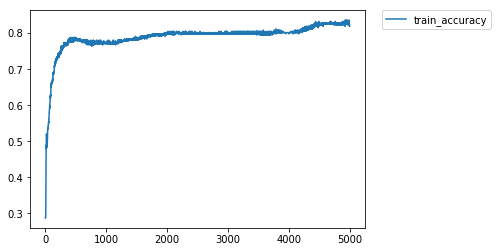

In [171]:
plt.plot(history.history['acc'], label = 'train_accuracy',)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [174]:
test_loss, test_acc = model.evaluate(test_pdf.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

98/98 [==============================] - 0s 991us/step
Test accuracy: 0.7959183673469388


In [177]:
y_hat = model.predict(test_pdf.drop('label', axis=1))
y_hat = y_hat.argmax(axis=1)
y_hat = label_encoder.inverse_transform(y_hat)

Text(0, 0.5, 'predicted')

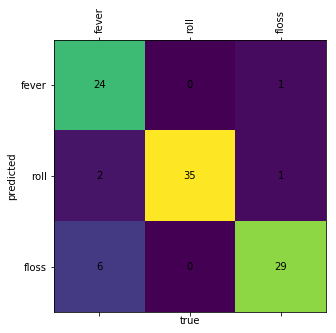

In [180]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_pdf['label'].value_counts().index)

confusion = confusion_matrix(test_labels, test_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [181]:
print(classification_report(test_labels, test_pred, labels=labels))

              precision    recall  f1-score   support

       fever       0.75      0.96      0.84        25
        roll       1.00      0.92      0.96        38
       floss       0.94      0.83      0.88        35

   micro avg       0.90      0.90      0.90        98
   macro avg       0.90      0.90      0.89        98
weighted avg       0.91      0.90      0.90        98



### Save the best model

In [247]:
import os
from pathlib import Path
from datetime import datetime as dt

save =  False 
ver = int(dt.now().timestamp())

if save:
    for fmt in ['pb', 'hdf5', 'json']:
        # save model as hdf5
        MODEL_DIR = f"new_models/{fmt}"
        export_path = Path(MODEL_DIR, str(ver))

        if fmt == 'pb':
            # simple_save can not handle existing repository
            !rm -r {export_path}

            # Inspired by https://www.tensorflow.org/serving/tutorials/Serving_REST_simple
            # to save model for TF-serving
            tf.saved_model.simple_save(
                tf.keras.backend.get_session(),
                str(export_path),
                inputs={'input_data': model.input},
                outputs={t.name:t for t in model.outputs})
            
        elif fmt == 'hdf5':
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            model_path = Path(export_path, 'saved_model.h5') 
            
            # hdf5
            model.save(model_path)
            
        else:
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            # json
            model_spec_path = Path(
                export_path, 'saved_model_spec.json'
            )
            model_weights_path = Path(
                export_path, 'checkpoint')
            
            model_spec_path.write_text(model.to_json(), encoding='utf-8')
            model.save_weights(str(model_weights_path))

        print('\nSaved model:')
        !ls -l {export_path}